# Equity models

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.BlackScholes import *
from src.Heston import *

from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

## Preliminary

### Generation of 2 correlated Brownian Motions

**Remark**: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.

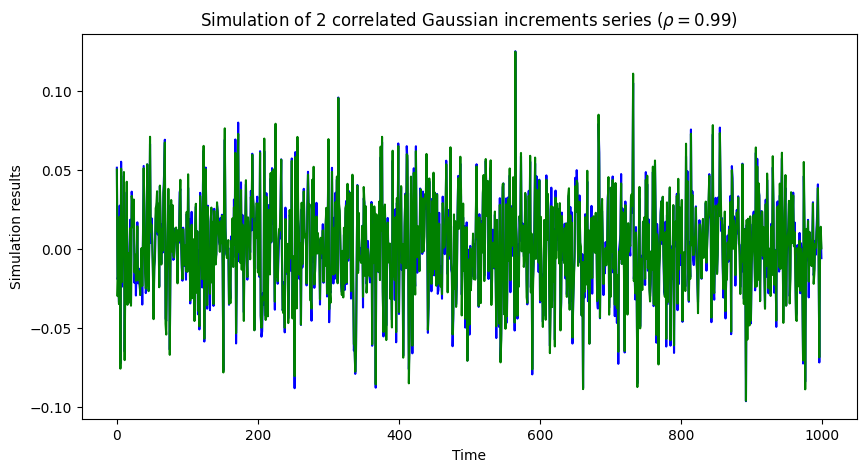

In [3]:
# Generation of Gaussian increments (Gaussian sequences)
rho_ = 0.99
for path in Utils.generate_correlated_gaussians(rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Gaussian increments series ($\rho =${rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

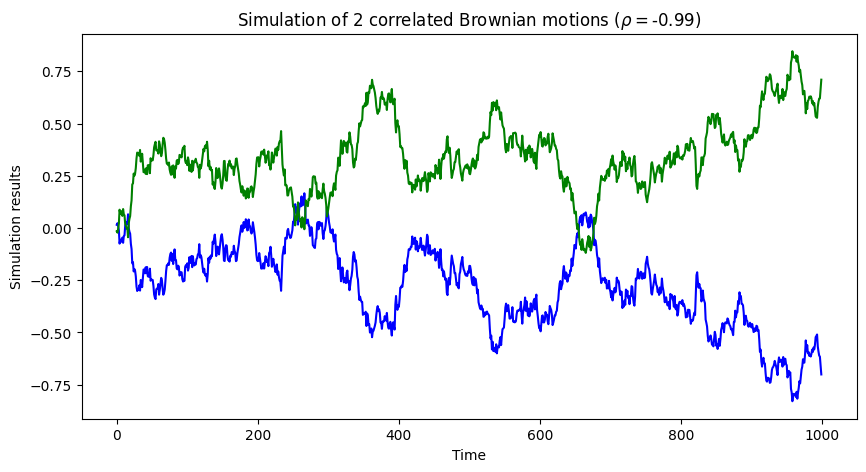

In [4]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(-rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Brownian motions ($\rho =${-rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

### Generation of $k > 2$ correlated Brownian Motions

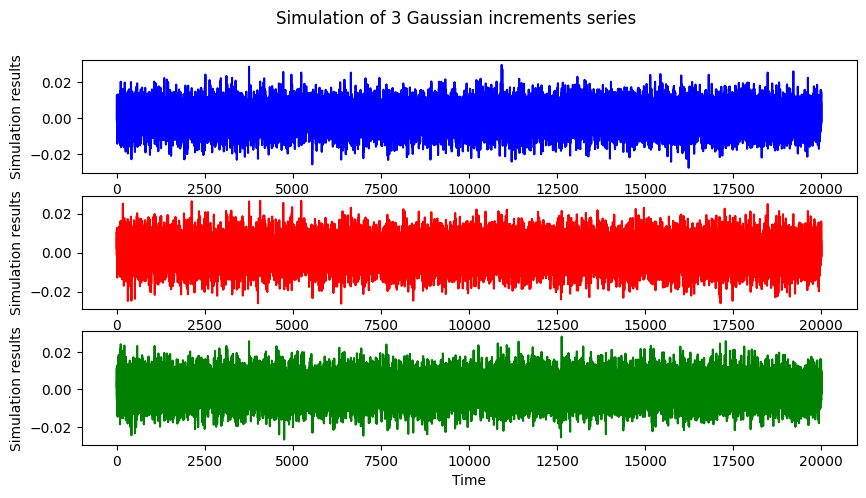

In [5]:
# Declaration of a correlation matrix
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])

colors = ["blue", "red", "green"]
# Simulation
sim_ = Utils.generate_correlated_gaussians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} Gaussian increments series")
_ = plt.xlabel("Time")

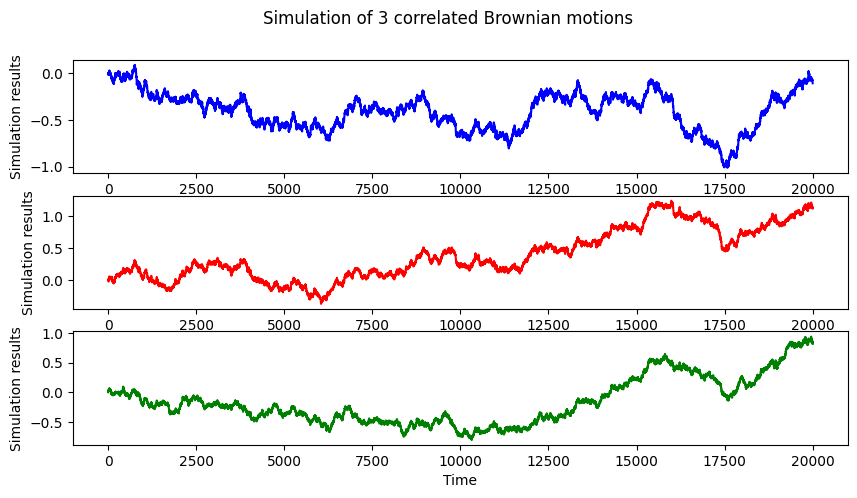

In [6]:
sim_ = Utils.generate_correlated_brownians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} correlated Brownian motions")
_ = plt.xlabel("Time")

## Black & Scholes

In [20]:
S0 = 1
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [21]:
model

Black-Scholes model (S0 = 1, sigma = 0.7)

In [9]:
# Simulation of 1 trajectory
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.00000,1.000000,0.400000
1,0.00021,1.001300,0.400682
2,0.00042,0.996561,0.400446
3,0.00063,1.004585,0.401630
4,0.00084,1.005848,0.401431


In [13]:
# Simulation of several trajectories
M_ = 3
Utils.cast_df(np.array(model.simulate_paths(M=M_)).T, columns = ["t"] + [f"S{k}" for k in range(1, M_ + 1)] )

,t,S1,S2,S3
0,0.00000,1.000000,1.000000,1.000000
1,0.00005,1.007620,0.999414,1.000951
2,0.00010,1.009799,1.002875,0.998014
3,0.00015,1.009935,1.002322,1.001241
4,0.00020,0.999630,0.984142,0.994423
...,...,...,...,...
19995,0.99975,3.630334,1.164842,1.313466
19996,0.99980,3.645775,1.166902,1.312275
19997,0.99985,3.638305,1.162851,1.314310
19998,0.99990,3.638804,1.158928,1.314437


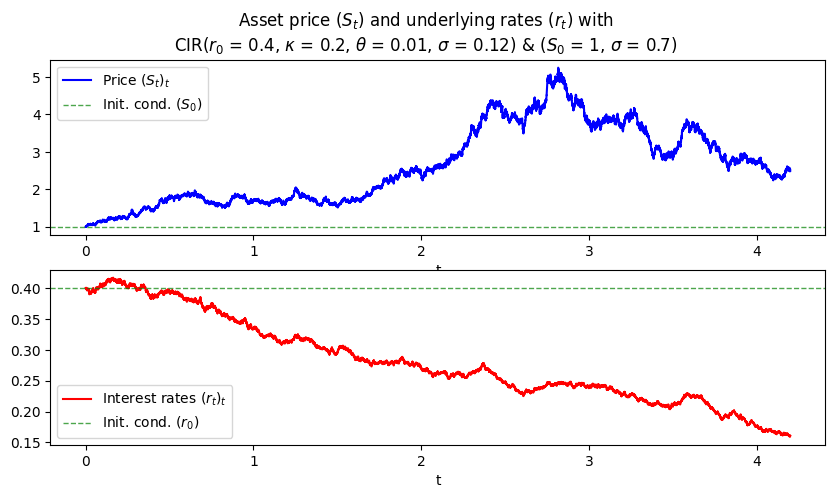

In [17]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

## Heston

In [17]:
# Declaring parameters
S0 = 1
V0 = 0.02
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])
sigma = 0.7
rho = 0.5
kappa = 0.20
theta = 0.02
eta = 0.06

# Declaring models (rate + equity)
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = Heston(S0, V0, r, kappa, theta, eta, Sigma) 

In [18]:
model

Heston model (S0 = 1, kappa = 0.2, theta = 0.02, eta = 0.06)

In [19]:
# Simulation of 1 trajectory
d = model.simulate_euler(getRates=True, getVariance=True)
df = pd.DataFrame(d)
df.head()

,t,S,V,r
0,0.00000,1.000000,0.020000,0.400000
1,0.00005,1.000420,0.019943,0.399990
2,0.00010,0.998981,0.019869,0.399774
3,0.00015,0.998612,0.019798,0.399721
4,0.00020,0.998112,0.019756,0.399552


In [44]:
# Simulation of several trajectories
NB_TRAJECTORIES = 20
df_2 = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
df_2.head()

,t,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
0,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.00005,1.000000,0.998987,1.000961,1.000056,0.998845,0.999686,0.998359,0.999203,1.001202,...,0.999317,1.000692,0.999382,1.000202,1.001889,0.999865,1.002347,1.000278,1.000524,0.999969
2,0.00010,1.001301,0.998840,1.001604,0.998944,0.997540,0.998723,0.997286,0.997011,0.999575,...,0.999621,1.000966,0.998400,1.000435,1.001814,1.001064,1.003704,1.000955,1.000261,0.997582
3,0.00015,1.002211,0.999606,1.002177,0.997694,0.998746,0.998926,0.996935,0.998226,0.999865,...,0.999982,1.001711,0.997023,0.998307,1.002598,1.000766,1.003687,1.000469,0.999453,0.997942
4,0.00020,1.003325,1.000191,1.002277,0.999180,0.998639,0.997523,0.996819,0.997875,0.999578,...,1.000705,1.000946,0.997470,0.998735,1.005136,0.998975,1.003520,1.000487,0.999804,0.999857


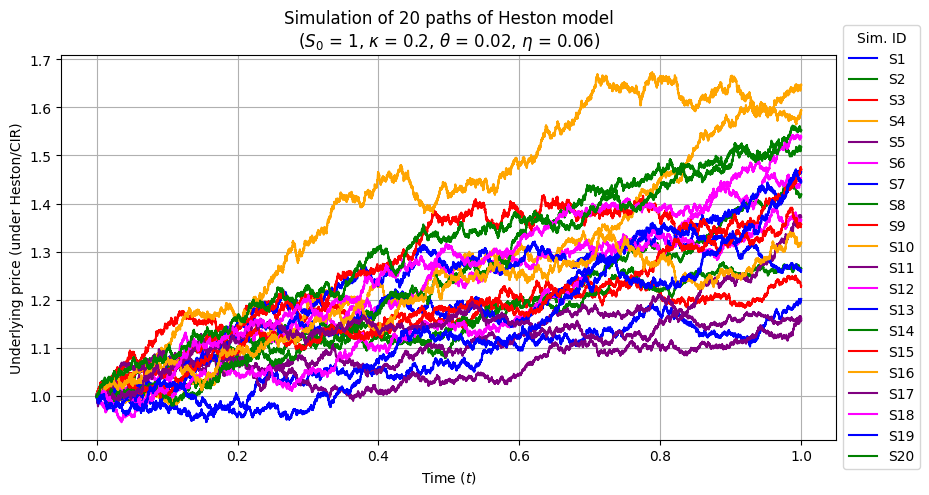

In [45]:
_ = df_2.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Underlying price (under Heston/CIR)")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Heston model\n{model.get_parameter_string()}")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Sim. ID")

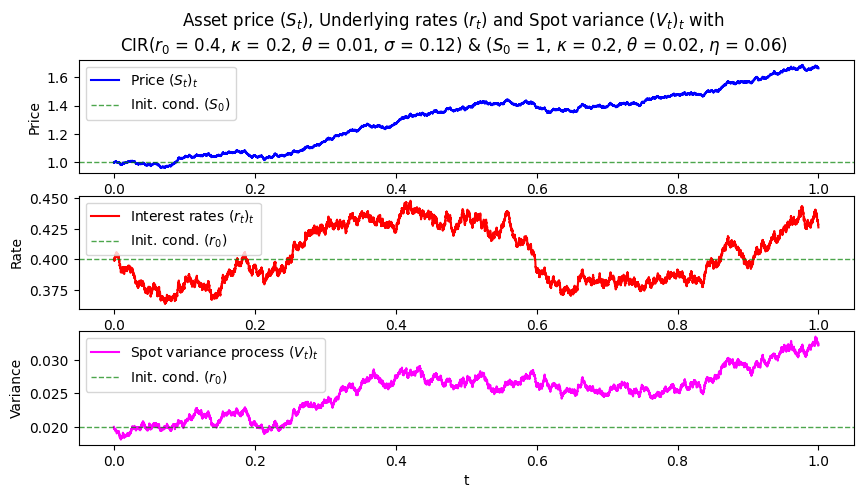

In [29]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=3, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
_ = df.plot(x = "t", y = "V", color="magenta", label="Spot variance process $(V_t)_t$", ax=axes[2])
_ = axes[2].axhline(y = model.V0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")

# Plotting options
axes[0].legend()
axes[0].set_ylabel("Price")
axes[1].legend()
axes[1].set_ylabel("Rate")
axes[2].legend()
axes[2].set_ylabel("Variance")
_ = plt.suptitle(f"Asset price $(S_t)$, Underlying rates $(r_t)$ and Spot variance $(V_t)_t$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")